# Adversarial dreaming test

Two different tests are provided:
* $\textbf{Test 1}$: perform an inception or adversarial dreaming on an image to fool a given deep model 
* $\textbf{Test 2}$: improve the deep model to avoid attacks like the one done in Test 1 (work in progress...)

In [3]:
# Import the necessary libraries
import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import keras
from keras.applications import inception_v3
from keras import backend as K
from keras import losses

import math
import collections
import io
import os
import numpy as np

import matplotlib.pyplot as plt

import random
from random import seed
seed(0)

## Test 1: fool the model

Run 'model.py' script to download the model and check the image

Labrador_retriever : 50.60% Confidence


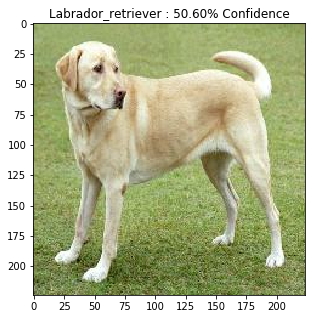

In [2]:
%run ./src/model.py

Load the model

In [3]:
tf.keras.backend.clear_session()
model = tf.keras.models.load_model('./src/assets/model.h5')
# Check its architecture
model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

Select the first Conv layer to perform the attack, modifying the image by calculating the gradient when that layer is activated. The idea is to slightly modify the original image on the basis of such activations, using the pattern inferred by the model

In [4]:
# Maximize the activations of first conv layer
layer = model.get_layer('Conv1').output
# Create the feature extraction model
fake_model = tf.keras.Model(inputs=model.input, outputs=layer)

The loss is the sum of the activations of the selected layer. Let's maximize that loss by gradient ascent

In [5]:
def calc_loss(img, model):
    # Pass forward the image through the model to retrieve the activations.
    # Converts the image into a batch of size 1.
    img_batch = tf.expand_dims(img, axis=0)
    layer_activations = model(img_batch)
    if len(layer_activations) == 1:
        layer_activations = [layer_activations]
    losses = []
    for act in layer_activations:
        loss = tf.math.reduce_mean(act)
        losses.append(loss)
    return  tf.reduce_sum(losses)

The gradients when the image is presented to the model are computed and added to it

In [6]:
class DeepFake(tf.Module):
    def __init__(self, model):
        self.model = model
    @tf.function(
        input_signature=(
            tf.TensorSpec(shape=[None,None,None,3], dtype=tf.float32),
            tf.TensorSpec(shape=[], dtype=tf.int32),
            tf.TensorSpec(shape=[], dtype=tf.float32),)
      )
    def __call__(self, img, steps, step_size):
        print("Tracing")
        loss = tf.constant(0.0)
        for n in tf.range(steps):
            with tf.GradientTape(persistent=True) as tape:
                # This needs gradients relative to `img`
                # `GradientTape` only watches `tf.Variable`s by default
                tape.watch(img)
                loss = calc_loss(img, self.model)
            # Calculate the gradient of the loss with respect to the pixels of the input image.
            gradients = tape.gradient(loss, img)
            # Normalize the gradients.
            gradients /= tf.math.reduce_std(gradients) + 1e-8 
            # In gradient ascent, the "loss" is maximized so that the input image increasingly "excites" the layers.
            # You can update the image by directly adding the gradients (because they're the same shape!)
            img = img + gradients*step_size
            img = tf.clip_by_value(img, -1, 1)
        return loss, img
    
deepfake = DeepFake(fake_model)

Methods to manipulate the image

In [7]:
# Normalize an image
def deprocess(img):
    img = 255*(img + 1.0)/2.0
    return tf.cast(img, tf.uint8)

# Display an image
def show(img):
    plt.figure()
    plt.imshow(img[0])
    
def run_deep_fake_simple(img, steps=100, step_size=0.01):
    img = tf.convert_to_tensor(img)
    step_size = tf.convert_to_tensor(step_size)
    steps_remaining = steps
    step = 0
    while steps_remaining:
        if steps_remaining>100:
            run_steps = tf.constant(100)
        else:
            run_steps = tf.constant(steps_remaining)
        steps_remaining -= run_steps
        step += run_steps
        loss, img = deepfake(img, run_steps, tf.constant(step_size))
        print ("Step {}, loss {}".format(step, loss))
    result = deprocess(img)
    show(result)
    return result

We can apply the parameters we want, but the idea is to perform a very tiny modification to the image: very few algorithm steps and a low step_size (setting value of the gradients)

Tracing
Step 10, loss -0.05120546370744705


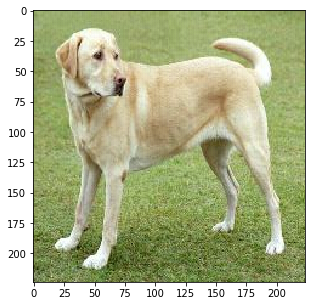

In [9]:
orig_img = load_image()
dream_img = run_deep_fake_simple(img=preprocess(orig_img), steps=10, step_size=0.001)

Check the prediction when the modified image is presented to the model

In [10]:
tf.keras.applications.mobilenet_v2.decode_predictions(model.predict(dream_img), top=1)[0][0]

('n04209239', 'shower_curtain', 0.8730727)

## Test 2: improve the model to avoid the attack

Run the script 'dataset.py' to download the images

In [11]:
%run ./src/dataset.py

Dataset saved at: /home/alberto/.keras/datasets/flower_photos


Load data, setting 80% for training and 20% for testing for validation purposes and in order to check the generalization capabilities of the model

In [24]:
flowers_path = '/home/alberto/.keras/datasets/flower_photos'
train_fraction = .8
random_seed = 1234

def make_train_and_test_sets():
    """Split the data into train and test sets and get the label classes."""
    train_examples, test_examples = [], []
    shuffler = random.Random(random_seed)
    is_root = True
    for (dirname, subdirs, filenames) in tf.gfile.Walk(flowers_path):
        # The root directory gives us the classes
        if is_root:
            subdirs = sorted(subdirs)
            classes = collections.OrderedDict(enumerate(subdirs))
            label_to_class = dict([(x, i) for i, x in enumerate(subdirs)])
            is_root = False
        # The sub directories give us the image files for training.
        else:
            filenames.sort()
            shuffler.shuffle(filenames)
            full_filenames = [os.path.join(dirname, f) for f in filenames]
            label = dirname.split('/')[-1]
            label_class = label_to_class[label]
            # An example is the image file and it's label class.
            examples = list(zip(full_filenames, [label_class] * len(filenames)))
            num_train = int(len(filenames) * train_fraction)
            train_examples.extend(examples[:num_train])
            test_examples.extend(examples[num_train:])

    shuffler.shuffle(train_examples)
    shuffler.shuffle(test_examples)
    return train_examples, test_examples, classes

In [25]:
train, test, labels = make_train_and_test_sets()
num_classes = len(labels)

print('\nThe dataset has %d label classes: %s' % (num_classes, labels.values()))
print('There are %d training images' % len(train))
print('there are %d test images' % len(test))


The dataset has 5 label classes: odict_values(['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips'])
There are 2934 training images
there are 736 test images


Methods to check and manage the data

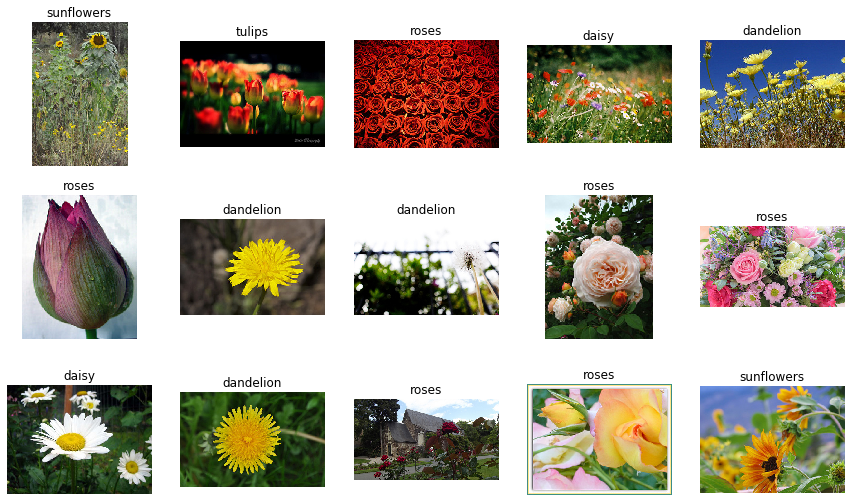

In [6]:
def get_label(example):
    """Get the label (number) for given example."""
    return example[1]

def get_class(example):
    """Get the class (string) of given example."""
    return labels[get_label(example)]

def get_encoded_image(example):
    """Get the image data (encoded jpg) of given example."""
    image_path = example[0]
    return tf.gfile.GFile(image_path, 'rb').read()

def get_image(example):
    """Get image as np.array of pixels for given example."""
    return plt.imread(io.BytesIO(get_encoded_image(example)), format='jpg')

def display_images(images_and_classes, cols=5):
    """Display given images and their labels in a grid."""
    rows = int(math.ceil(len(images_and_classes) / cols))
    fig = plt.figure()
    fig.set_size_inches(cols * 3, rows * 3)
    for i, (image, flower_class) in enumerate(images_and_classes):
        plt.subplot(rows, cols, i + 1)
        plt.axis('off')
        plt.imshow(image)
        plt.title(flower_class)

num_images = 15
display_images([(get_image(example), get_class(example))
               for example in train[:num_images]])

Data preprocessing

In [26]:
# Shuffle the labels and images randomly for better results
union_list = list(zip(train, labels))
random.shuffle(union_list)
train, labels = zip(*union_list)
# Convert the shuffled list to numpy array type
train = np.array(train)
labels = np.array(labels)

First, we define a very simple model to see how it goes

In [16]:
def flowers_model(train, labels, epochs=5):
    # Develop a sequential model using tensorflow keras
    model = keras.Sequential([
        keras.layers.Flatten(input_shape=(64,64,3)),
        keras.layers.Dense(128, activation=tf.nn.tanh),
        keras.layers.Dense(5, activation=tf.nn.softmax)
    ])
    # Compute the model parameters
    model.compile(optimizer=tf.train.AdamOptimizer(), 
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    # Train the model  with 5 epochs 
    model.fit(train, labels, epochs=epochs)

PENDING: train and validate the model, apply the approach presented in Test 1 to one image and check if the model is able to correctly classify it, improve the model if needed by, for instance, adding diversity to the original dataset by randomly manipulating the images...